In [5]:
import os
import shutil
from pathlib import Path

import pycolmap
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from hloc import localize_sfm, visualization
from hloc.localize_sfm import QueryLocalizer, pose_from_cluster
from hloc.utils.io import list_h5_names, get_matches, get_keypoints
from hloc.visualization import plot_images, plot_keypoints, plot_matches, read_image, add_text, cm_RdGn

In [13]:
DIR = Path("../imc_data")
MODE = "train"
NAME = "DISK+LG-rot"
dataset = "heritage" # "heritage", "haiper", "urban"
scene = "cyprus" # "dioscuri", "cyprus", "wall", "kyiv-puppet-theater", "bike", "chairs", "fountain"

OUT = Path("../outputs") / NAME

In [47]:
class DataPaths:
    def __init__(self, data_dir: str, output_dir: str, dataset: str, scene: str, mode: str):
        """Class to store paths.

        Args:
            data_dir (str): Path to data directory.
            output_dir (str): Path to output directory.
            dataset (str): Dataset name.
            scene (str): Scene name.
            mode (str): Mode (train or test).
        """
        if mode not in {"train", "test"}:
            raise ValueError(f"Invalid mode: {mode}")

        self.input_dir = Path(f"{data_dir}/{mode}/{dataset}/{scene}")
        self.scene_dir = output_dir / dataset / scene
        self.image_dir = self.input_dir / "images-resized"

        self.sfm_dir = self.scene_dir / "sparse"
        self.pairs_path = self.scene_dir / "pairs.txt"
        self.features_retrieval = self.scene_dir / "features_retrieval.h5"
        self.features_path = self.scene_dir / "features.h5"
        self.matches_path = self.scene_dir / "matches.h5"

        # for rotation matching
        self.rotated_image_dir = self.scene_dir / "images_rotated"
        self.rotated_features_path = self.scene_dir / "features_rotated.h5"

        # TODO: Update this.
        self.cache = self.scene_dir / "cache"

        # create directories
        self.scene_dir.mkdir(parents=True, exist_ok=True)
        self.image_dir.mkdir(parents=True, exist_ok=True)
        self.sfm_dir.mkdir(parents=True, exist_ok=True)
        self.rotated_image_dir.mkdir(parents=True, exist_ok=True)
        self.cache.mkdir(parents=True, exist_ok=True)

paths = DataPaths(DIR, OUT, dataset, scene, MODE)

for p in paths.__getattribute__("__dict__"):
    print(p, paths.__getattribute__(p))

input_dir ../imc_data/train/heritage/cyprus
scene_dir ../outputs/DISK+LG-rot/heritage/cyprus
image_dir ../imc_data/train/heritage/cyprus/images-resized
sfm_dir ../outputs/DISK+LG-rot/heritage/cyprus/sparse
pairs_path ../outputs/DISK+LG-rot/heritage/cyprus/pairs.txt
features_retrieval ../outputs/DISK+LG-rot/heritage/cyprus/features_retrieval.h5
features_path ../outputs/DISK+LG-rot/heritage/cyprus/features.h5
matches_path ../outputs/DISK+LG-rot/heritage/cyprus/matches.h5
rotated_image_dir ../outputs/DISK+LG-rot/heritage/cyprus/images_rotated
rotated_features_path ../outputs/DISK+LG-rot/heritage/cyprus/features_rotated.h5
cache ../outputs/DISK+LG-rot/heritage/cyprus/cache


In [48]:
model = pycolmap.Reconstruction(str(paths.sfm_dir))
print(model.summary())

Reconstruction:
	num_reg_images = 13
	num_cameras = 1
	num_points3D = 1174
	num_observations = 2724
	mean_track_length = 2.32027
	mean_observations_per_image = 209.538
	mean_reprojection_error = 1.06119


In [49]:
images = os.listdir(paths.rotated_image_dir)
registered_images = [im.name for im in model.images.values()]
unregistered_images = [name for name in images if name not in registered_images]

len(images), len(registered_images), len(unregistered_images)

(30, 13, 17)

In [50]:
query_path = paths.image_dir.parent / "queries"
if not query_path.exists():
    query_path.mkdir(parents=True)

for im in unregistered_images:
    shutil.copy(paths.image_dir / im, query_path / im)

# Plot Queries

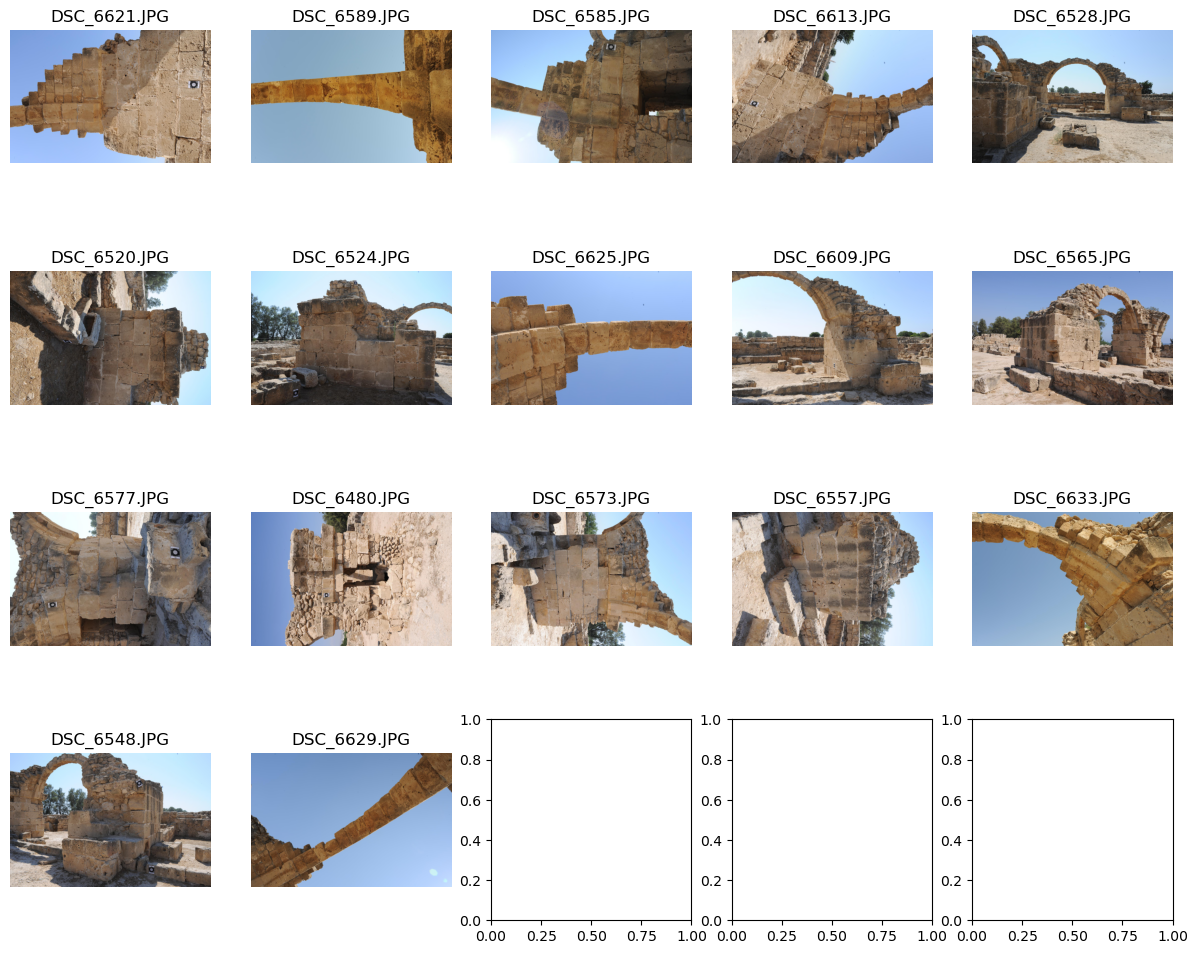

In [51]:
n_cols = 5
n_rows = int(np.ceil(len(unregistered_images) / n_cols))

fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3, n_rows * 3))
axs = axs.flatten()
for i, im in enumerate(unregistered_images):
    axs[i].imshow(read_image(paths.image_dir / im))
    axs[i].set_title(im)
    axs[i].axis("off")

# Load matches

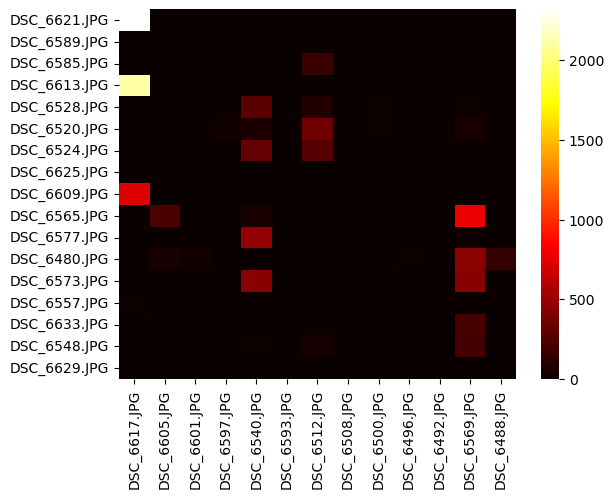

In [52]:
image_names = sorted(list_h5_names(paths.features_path))
pairs = sorted(list_h5_names(paths.matches_path))

match_matrix = -np.ones([len(unregistered_images), len(registered_images)])
for pair in pairs:
    name0, name1 = pair.split("/")
    m, sc = get_matches(paths.matches_path, name0, name1)

    if name0 in unregistered_images and name1 in registered_images:
        idx0, idx1 = unregistered_images.index(name0), registered_images.index(name1)
        match_matrix[idx0, idx1] = m.shape[0]

    elif name1 in unregistered_images and name0 in registered_images:
        idx0, idx1 = unregistered_images.index(name1), registered_images.index(name0)
        match_matrix[idx0, idx1] = m.shape[0]


ax = sns.heatmap(
    match_matrix, 
    linewidth=0.0, 
    cmap="hot",
    yticklabels=unregistered_images,
    xticklabels=registered_images,
    mask=match_matrix < 0
)

In [53]:
# get most matcher per unregsietered image
best_matches = np.max(match_matrix, axis=1)

queries = list(zip(unregistered_images, best_matches))

sorted_queries = sorted(queries, key=lambda x: x[1], reverse=True)

sorted_queries[:10]

[('DSC_6621.JPG', 2320.0),
 ('DSC_6613.JPG', 2116.0),
 ('DSC_6565.JPG', 794.0),
 ('DSC_6609.JPG', 734.0),
 ('DSC_6577.JPG', 478.0),
 ('DSC_6480.JPG', 449.0),
 ('DSC_6573.JPG', 442.0),
 ('DSC_6520.JPG', 345.0),
 ('DSC_6524.JPG', 309.0),
 ('DSC_6528.JPG', 274.0)]

DSC_6621.JPG DSC_6617.JPG


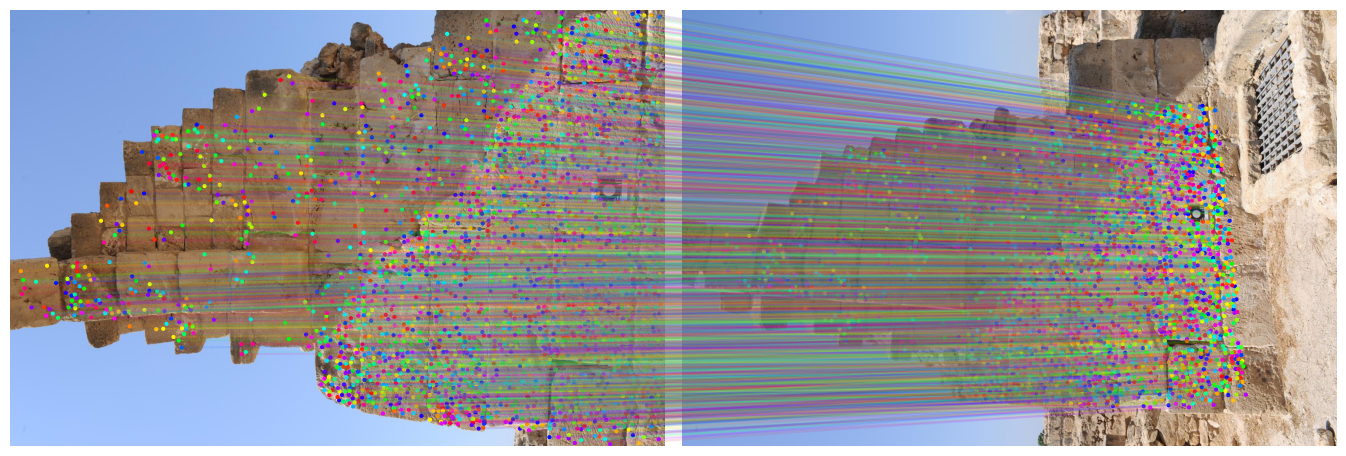

DSC_6613.JPG DSC_6617.JPG


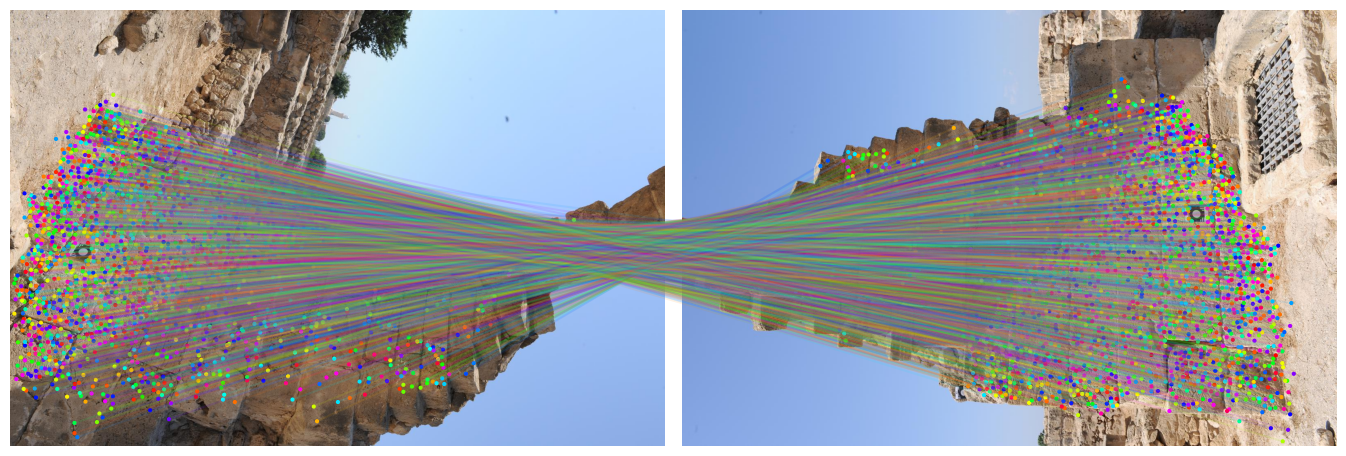

DSC_6565.JPG DSC_6569.JPG


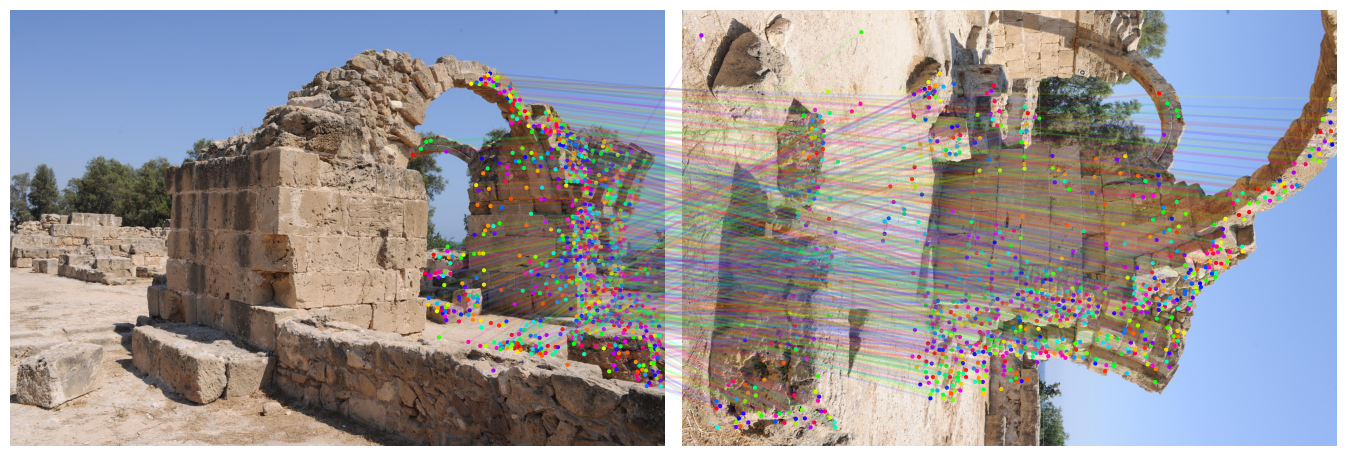

DSC_6609.JPG DSC_6617.JPG


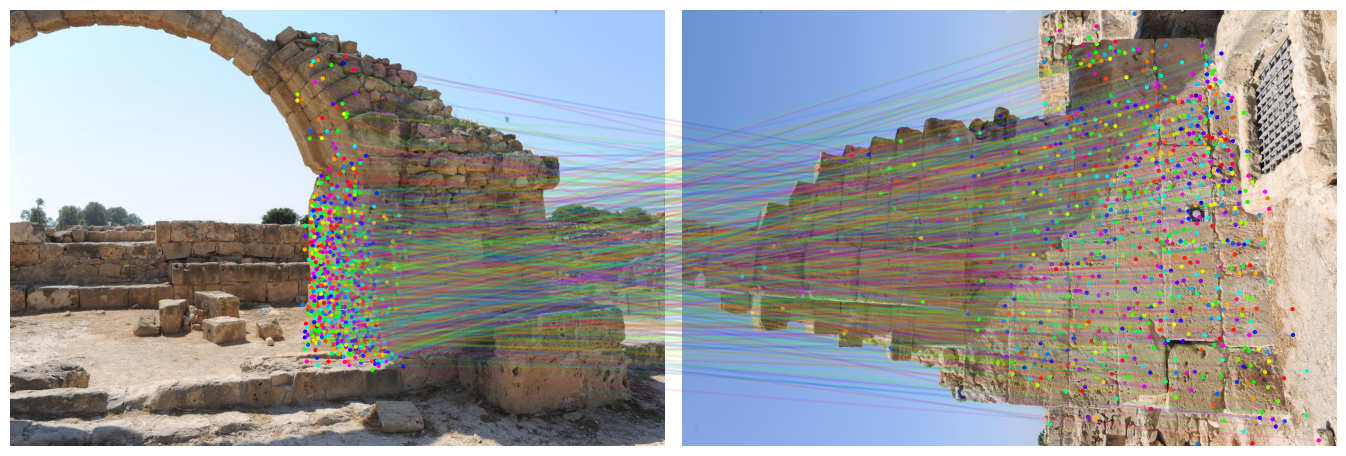

DSC_6577.JPG DSC_6540.JPG


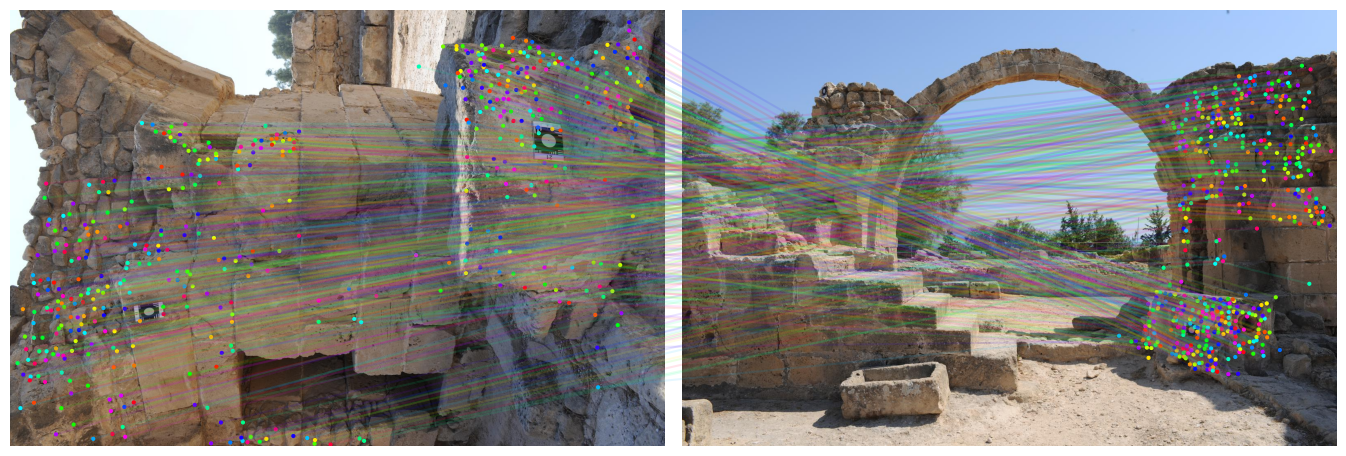

In [59]:
# plot the best matches
for query, score in sorted_queries[:5]:
    best_match_idx = np.argmax(match_matrix[unregistered_images.index(query)])
    best_match = registered_images[best_match_idx]
    
    name0 = query
    name1 = best_match
    print(name0, name1)

    plot_images([read_image(paths.image_dir / name0), read_image(paths.image_dir / name1)])
    kp0, kp1 = get_keypoints(paths.features_path, name0), get_keypoints(paths.features_path, name1)
    m, sc = get_matches(paths.matches_path, name0, name1)
    plot_matches(kp0[m[:,0]], kp1[m[:,1]], a=0.1)

    plt.show()

# Localize

In [60]:
query_image = sorted_queries[0][0]

In [61]:
with open(paths.pairs_path, "r") as f:
    pairs = [l.split() for l in f.readlines()]
    
pairs = [(p[0], p[1]) for p in pairs]

found 56/73 inlier correspondences.


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

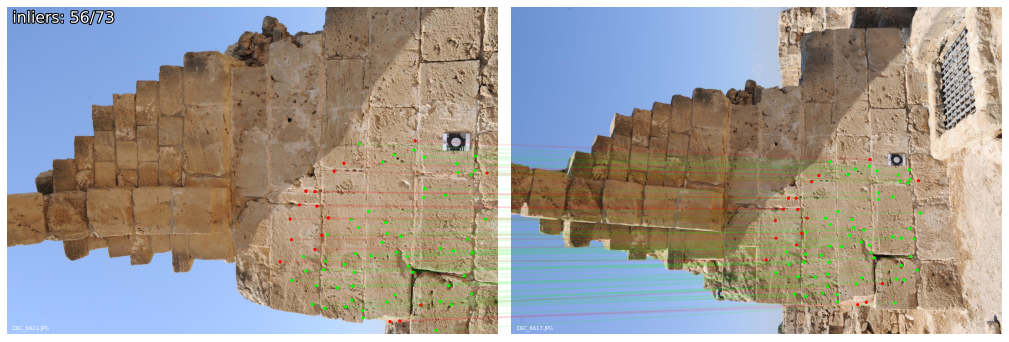

In [62]:
for query_image in sorted_queries:
    query_image = query_image[0]

    ref_pairs = [p for p in pairs if query_image in p]
    ref_names = [p[0] if p[0] != query_image else p[1] for p in ref_pairs]
    ref_names = [name for name in ref_names if name in registered_images]
    ref_ids = [model.find_image_with_name(name).image_id for name in ref_names]

    # ref_names = ["archive_0033.png"]
    # ref_ids = [model.find_image_with_name(name).image_id for name in ref_names]


    # taken from Hierarchical-Localization/demo.ipynb
    camera = pycolmap.infer_camera_from_image(paths.image_dir / query_image)

    conf = {
        'estimation': {'ransac': {'max_error': 12}},
        'refinement': {'refine_focal_length': True, 'refine_extra_params': True},
    }
    localizer = QueryLocalizer(model, conf)
    ret, log = pose_from_cluster(localizer, query_image, camera, ref_ids, paths.features_path, paths.matches_path)

    print(f'found {ret["num_inliers"]}/{len(ret["inliers"])} inlier correspondences.')
    visualization.visualize_loc_from_log(paths.image_dir, query_image, log, model)
    plt.show()